<a href="https://colab.research.google.com/github/Geu-Pro2023/Streamlit-ML/blob/main/Copy_of_Geu_Aguto_Summative_Assignment_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Optimization Techniques in Machine Learning**

### **Project: WildGuard_Classification_Model**

##### This project focuses on classifying wild animals as endangered or non-endangered using machine learning models.
It explores the implementation of Convolutional Neural Networks (CNNs) and classical machine learning algorithms (e.g., Logistic Regression, Random Forest) while applying optimization techniques such as regularization, dropout, and early stopping. The goal is to improve model performance, convergence speed, and efficiency.

### **Overview of the Data**

**The dataset consists of images of wild animals categorized into two classes:**

   1. Endangered: Animals at risk of extinction.
   2. Non-Endangered: Animals not currently at risk.
      
**Dataset Details**

**Source:** Publicly available dataset on kaggle: **90-different-animals-image-classification**
   1. Size: Approximately 1,000 images (500 per class) but used 600 images (300 per class).
   2. Format: Images are resized to 150x150 pixels and normalized to the range [0, 1].

### **Import Libraries**

In [128]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import cv2
import pickle
import random
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import save_model

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load the dataset**

In [130]:
DIRECTORY = "/content/drive/MyDrive/animals"
CATEGORIES = ['Endangered', 'Non-Endangered']

In [131]:
DIR = "/content/drive/MyDrive/animals"
IMG_SIZE = 150

### **Join the Image Path and the Image Categories**

In [132]:
for category in CATEGORIES:
  path = os.path.join(DIRECTORY,category)
  print(path)

/content/drive/MyDrive/animals/Endangered
/content/drive/MyDrive/animals/Non-Endangered


In [133]:
print(os.listdir(DIRECTORY))

['Endangered', 'Non-Endangered']


### **Check the number of images in each catergory**

In [134]:
#Counting the number of files in each category
endangered_count = len(os.listdir(os.path.join(DIRECTORY, 'Endangered')))
non_endangered_count = len(os.listdir(os.path.join(DIRECTORY, 'Non-Endangered')))

print(f"Endangered samples: {endangered_count}")
print(f"Non-Endangered samples: {non_endangered_count}")

Endangered samples: 300
Non-Endangered samples: 300


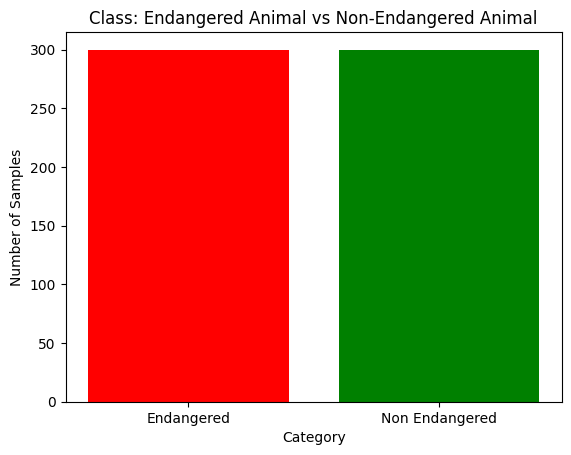

In [135]:
labels = ['Endangered', 'Non Endangered']
counts = [endangered_count, non_endangered_count]

plt.bar(labels, counts, color=['red', 'green'])
plt.title('Class: Endangered Animal vs Non-Endangered Animal')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()

### **Check the outliers in the image dataset**

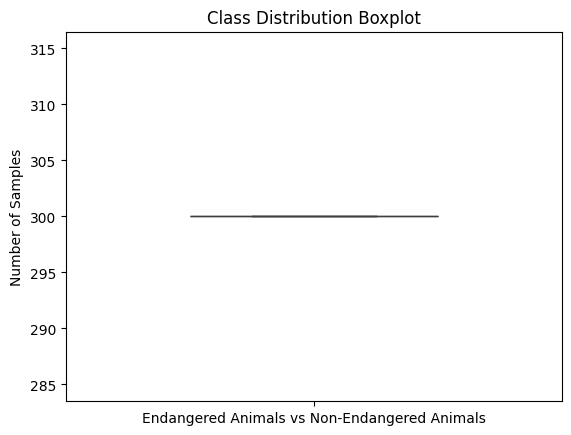

In [136]:
#Create a boxplot to visualize the distribution and potential outliers
data = [endangered_count, non_endangered_count]

sns.boxplot(data=data, width=0.5)
plt.xticks([0], ['Endangered Animals vs Non-Endangered Animals'])
plt.title('Class Distribution Boxplot')
plt.ylabel('Number of Samples')
plt.show()

### **List Image in the folder**

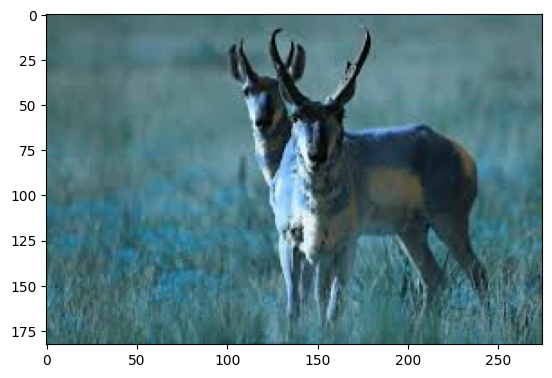

In [137]:
for category in CATEGORIES:
  path = os.path.join(DIRECTORY,category)
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    img_arr = cv2.imread(img_path)
    plt.imshow(img_arr)
    break

### **Resizing the image**

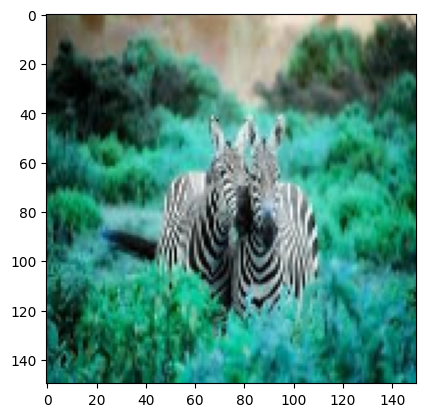

In [138]:
for category in CATEGORIES:
  path = os.path.join(DIRECTORY,category)
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
    plt.imshow(img_arr)

### **Display the images in both catergories with their actual sizes**

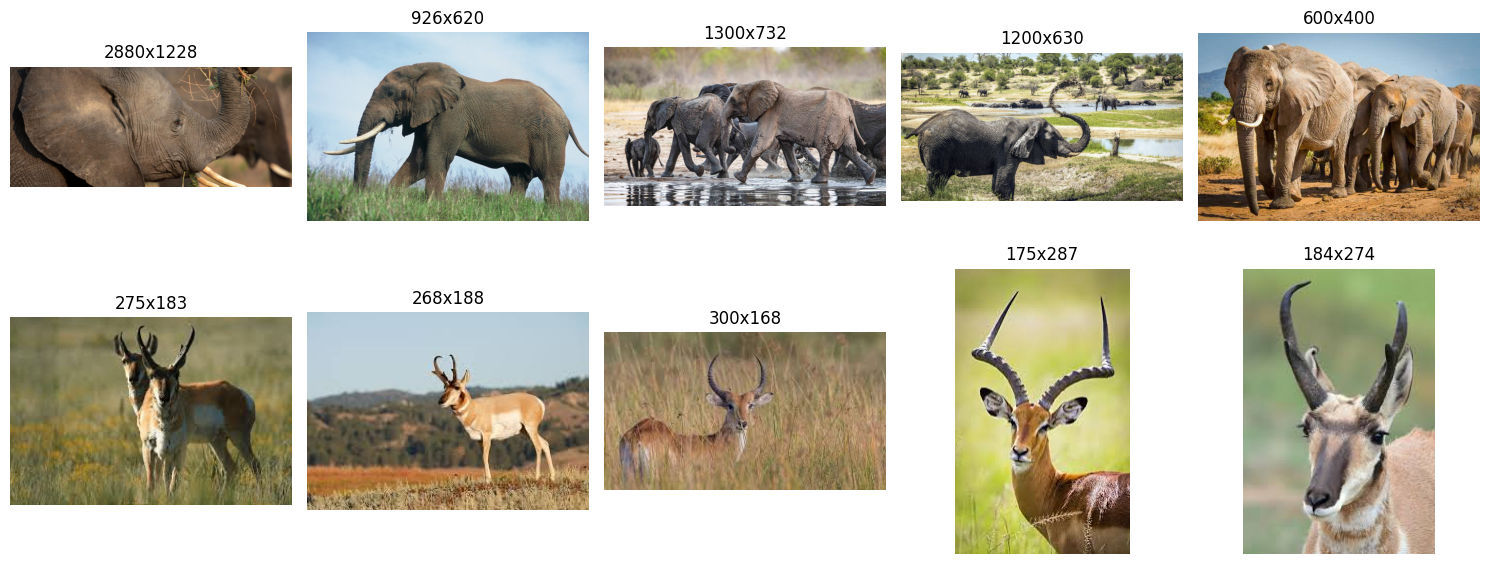

In [140]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
i = 0
for cat in CATEGORIES:
    for filename in os.listdir(os.path.join(DIR, cat))[:5]:
        img_path = os.path.join(DIR, cat, filename)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        axes.flat[i].imshow(img)
        axes.flat[i].set_title(f"{w}x{h}")
        axes.flat[i].axis("off")
        i += 1
plt.tight_layout()
plt.show()

### **Resizing all the images for training**

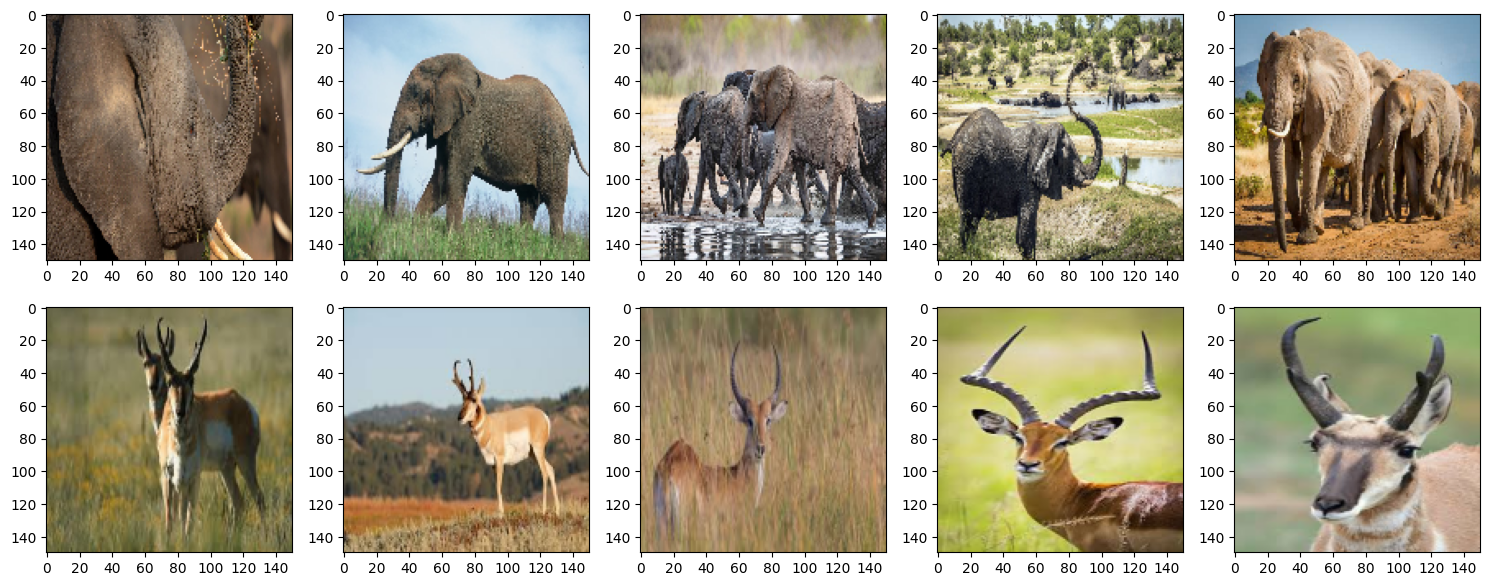

In [141]:
#Resize all the images in the dataset before training the model
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
i = 0
for cat in CATEGORIES:
    for filename in os.listdir(os.path.join(DIR, cat))[:5]:
        img_path = os.path.join(DIR, cat, filename)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        axes.flat[i].imshow(img_resized)
        axes.flat[i].axis("on")

        axes.flat[i].set_xticks(range(0, IMG_SIZE, 20))
        axes.flat[i].set_yticks(range(0, IMG_SIZE, 20))
        axes.flat[i].axis('on')
        i += 1

plt.tight_layout()
plt.show()

In [142]:
#Join the total number of images in both catergories
data = []
for category in CATEGORIES:
  path = os.path.join(DIRECTORY,category)
  label = CATEGORIES.index(category)
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
    data.append([img_arr,label])

In [143]:
len(data)

600

### **Randomizing the data and splitting into input matrix (X) and output vector (y)**

In [144]:
# Shuffle the data
random.shuffle(data)

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Normalize the images to the range [0, 1]
X = X / 255.0
print(X.shape)

(600, 150, 150, 3)


In [ ]:
# Save the processed data
pickle.dump(X, open('X.pkl', 'wb'))
pickle.dump(y, open('y.pkl', 'wb'))

### **Split the data into training, testing, and validation sets**

In [145]:
# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (360, 150, 150, 3)
Test data shape: (120, 150, 150, 3)
Validation data shape: (120, 150, 150, 3)


### [](http://)**Define Neural Network**

#Model architecture

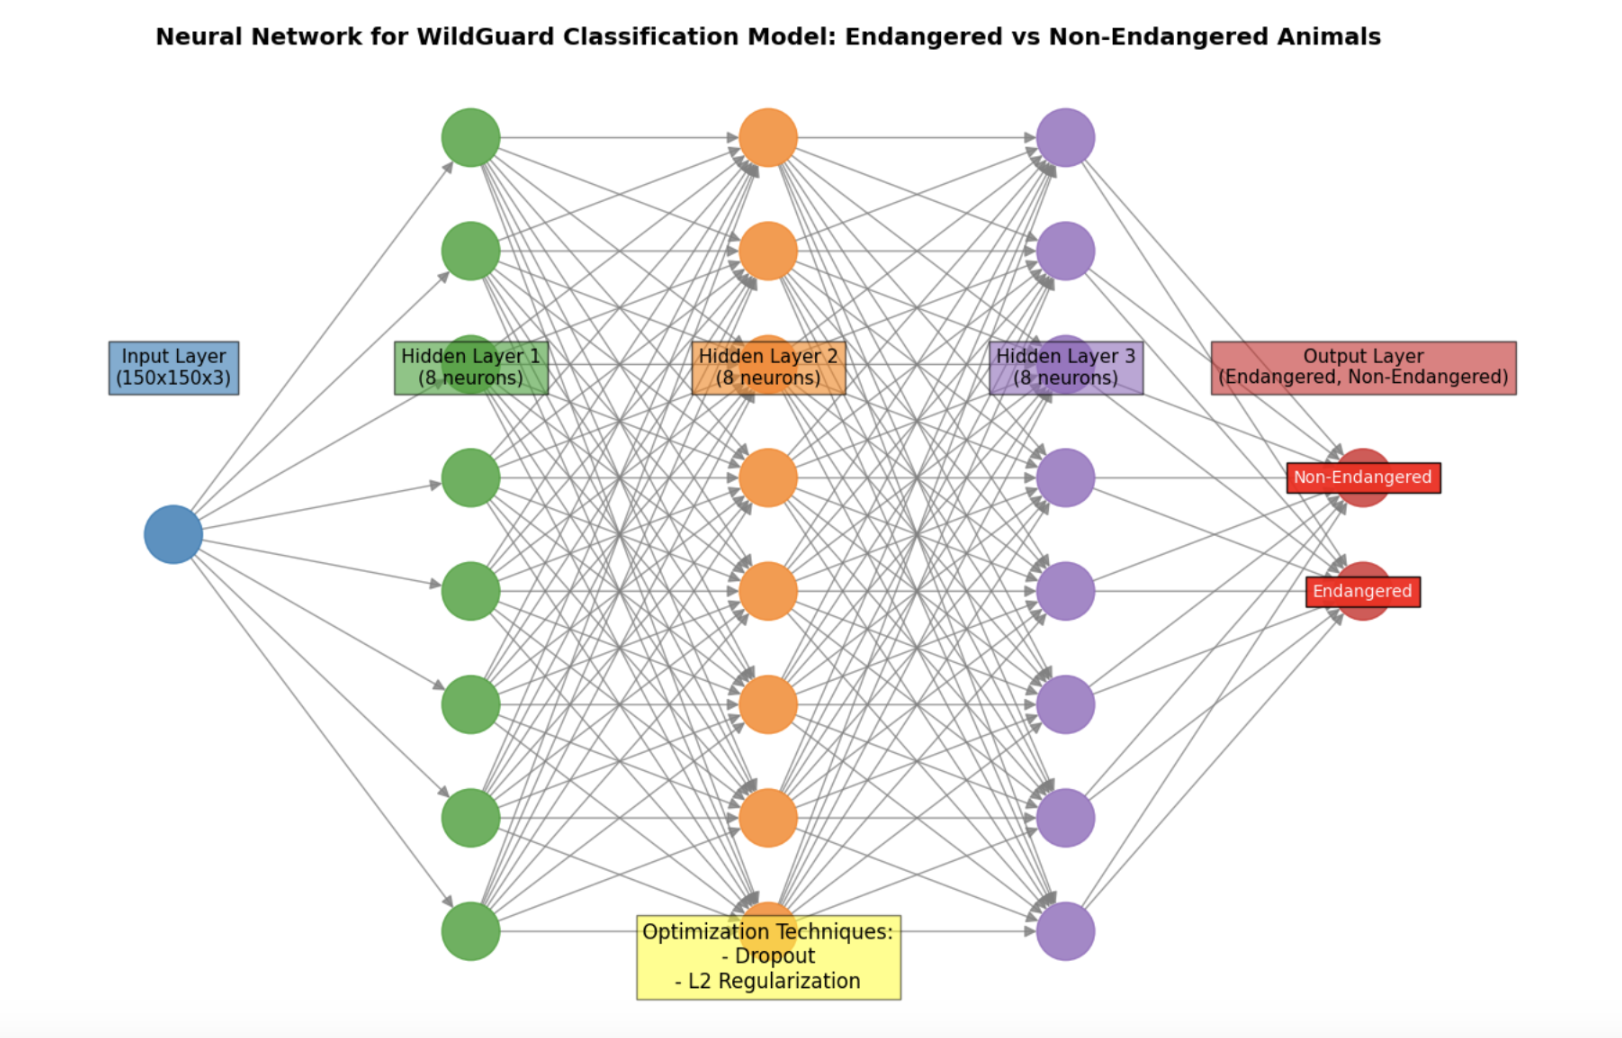

In [146]:
#Define a function that creates models without and With specified Optimization techniques
def define_model(optimizer='adam', regularizer=None, early_stopping=False, dropout_rate=0.0, learning_rate=0.001):
    """
    Define a CNN model with specified optimization techniques.

    Args:
        optimizer (str): Optimizer to use ('adam' or 'rmsprop').
        regularizer (keras.regularizers.Regularizer or None): Regularizer function.
        early_stopping (bool): Whether to use early stopping (not used inside function).
        dropout_rate (float): Dropout rate (0.0 means no dropout).
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model: Compiled Keras model.
    """
    #Define the model architecture
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3),
               kernel_regularizer=regularizer if regularizer else None),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizer if regularizer else None),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizer if regularizer else None),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizer if regularizer else None),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    #Define the optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer must be 'adam' or 'rmsprop'.")

    #Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

#### **Model 2: CNN with L2 Regularization**

In [147]:
#Model2: CNN with L2 Regularization
l2_reg = l2(0.001)
model2 = define_model(optimizer='adam', regularizer=l2_reg, dropout_rate=0.0)
model2.summary()
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5013 - loss: 1.1908 - val_accuracy: 0.6417 - val_loss: 0.8949
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 913ms/step - accuracy: 0.6327 - loss: 0.8808 - val_accuracy: 0.5000 - val_loss: 0.8613
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 907ms/step - accuracy: 0.5651 - loss: 0.8275 - val_accuracy: 0.5333 - val_loss: 0.8117
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 905ms/step - accuracy: 0.6019 - loss: 0.8000 - val_accuracy: 0.6000 - val_loss: 0.7785
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 909ms/step - accuracy: 0.5965 - loss: 0.7632 - val_accuracy: 0.5083 - val_loss: 0.8688
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 847ms/step - accuracy: 0.6253 - loss: 0.7608 - val_accuracy: 0.5083 - val_loss: 0.7844
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 849ms/step - accuracy: 0.6292 - loss: 0.7141 - val_accuracy: 0.6417 - val_loss: 0.7484
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 869ms/step - accuracy: 0.7506 - loss: 0.6318 - val_accurac

#### **Confusion Matrix for CNN with L2 Regularization**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


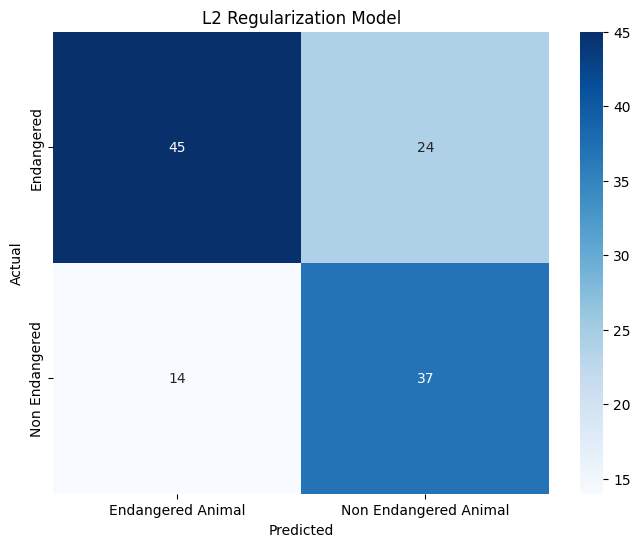

In [148]:
#CNN with L2 Regularization)
y_pred5 = model2.predict(X_test)
y_pred5 = (y_pred5 > 0.5).astype(int)

cm6 = confusion_matrix(y_test, y_pred5)

plt.figure(figsize=(8, 6))
sns.heatmap(cm6, annot=True, fmt='d', cmap='Blues', xticklabels=['Endangered Animal', 'Non Endangered Animal'], yticklabels=['Endangered', 'Non Endangered'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('L2 Regularization Model')
plt.show()

### **Plot the Models Accuracy and plot the Loss curve**

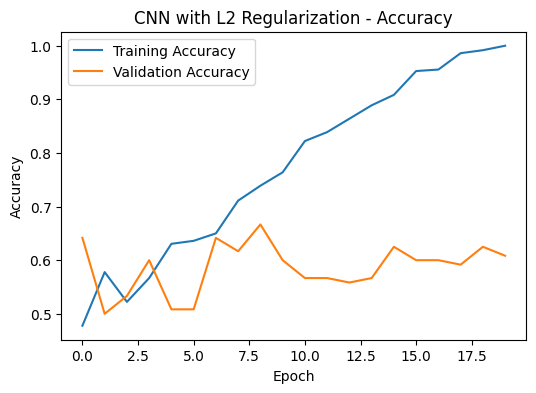

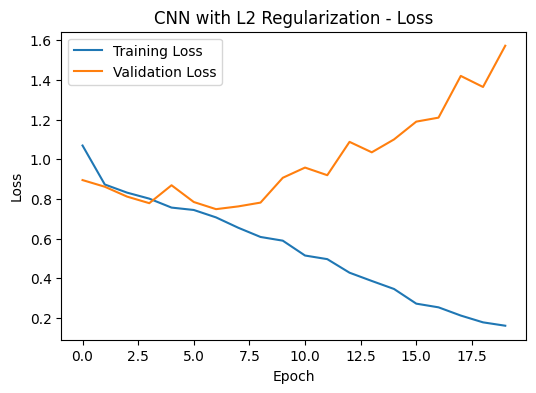

In [149]:
#Plot loss and accuracy curves for each model

# Store model history in a dictionary
results = {
    "CNN with L2 Regularization": history2
}

# Plot loss and accuracy curves for each model
for model_name, history in results.items():
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [150]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the given model on the test dataset.

    Args:
        model: Trained Keras model.
        X_test: Test features.
        y_test: Test labels.

    Returns:
        test_loss: Loss value on the test set.
        test_accuracy: Accuracy on the test set.
    """
    #Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    #Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy


In [151]:
#Evaluate Model2 (CNN with L2 Regularization)
test_loss, test_accuracy = evaluate_model(model2, X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.6702 - loss: 1.4782
Test Loss: 1.3442
Test Accuracy: 0.6833


### **Save Models**

In [154]:
#save the model
def save_models(models_dict, directory='saved_models'):

    #Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

    #Save each model
    for model_name, model in models_dict.items():
        filepath = os.path.join(directory, f"{model_name}.h5")
        save_model(model, filepath)
        print(f"Saved {model_name} to {filepath}")

In [155]:
#Save the model
def save_model2(model, directory='saved_models'):

    #Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

    #Save the model2
    filepath = os.path.join(directory, "model2_l2_adam")
    save_model(model, filepath)
    print(f"Saved model2 to {filepath}")

In [156]:
#Dictionary of models to save
models_dict = {
    "model2_l2_adam": model2
}
#Save the models
save_models(models_dict)

Created directory: saved_models
Saved model2_l2_adam to saved_models/model2_l2_adam.h5


### **Load the best Model**

In [157]:
#Define the dataset path and categories
DATASET_PATH = '/content/drive/MyDrive/animals'
CATEGORIES = ['Endangered', 'Non-Endangered']

#Load the model trained
model_path = '/content/saved_models/model2_l2_adam.h5'
model2 = load_model(model_path)
print("Model loaded successfully!")

Model loaded successfully!


### **Make Predictions using the best saved model**

In [158]:
def preprocess_image(image_path):
    """
    Given an image path, loads the image, converts it to RGB, resizes it to (150, 150),
    and prepares it for model prediction.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (150, 150))  # Resize to match model input size (150x150)
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Add batch dimension
    img = img / 255.0  # Normalize image if your model was trained with normalized data
    return img

def find_image_path(image_filename):
    """
    Searches for the image filename in all category folders.
    Returns the full path if found; raises FileNotFoundError otherwise.
    """
    for category in CATEGORIES:
        candidate = os.path.join(DATASET_PATH, category, image_filename)
        if os.path.exists(candidate):
            return candidate
    raise FileNotFoundError(f"Image {image_filename} not found in any category folder.")

def predict_and_display(image_filename):
    # Find the image path automatically by searching through categories
    image_path = find_image_path(image_filename)
    print(f"Using image: {image_path}")

    # Preprocess the image
    img = preprocess_image(image_path)

    # Predict with the model
    prediction = model2.predict(img)
    predicted_class = np.argmax(prediction, axis=1)  # Get the class with the highest probability
    prediction_label = "Endangered" if predicted_class[0] == 1 else "Non-Endangered"

    # Load and display the image
    img_to_display = cv2.imread(image_path)
    if img_to_display is None:
        raise ValueError(f"Failed to load image for display: {image_path}")
    img_rgb = cv2.cvtColor(img_to_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {prediction_label}")
    plt.axis('off')
    plt.show()

    print(f"🔍 Prediction for {image_path}: {prediction_label}")

In [159]:
#Show first 5 images path of the dataset for prediction
print(os.listdir("/content/drive/MyDrive/animals/Endangered")[:5])
print(os.listdir("/content/drive/MyDrive/animals/Non-Endangered")[:5])

['4dacf9a3f0.jpg', '2cb580feff.jpg', '6ecfd5e88c.jpg', '48fe954ed2.jpg', '5c8e73a595.jpg']
['68eb12a751.jpg', '82e0981104.jpg', '9b9623816d.jpg', '8a55e17288.jpg', '9a58695d48.jpg']


Using image: /content/drive/MyDrive/animals/Endangered/5c8e73a595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


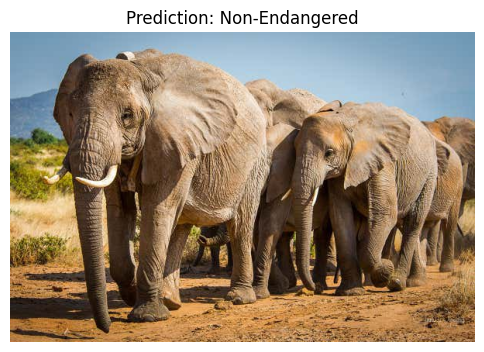

🔍 Prediction for /content/drive/MyDrive/animals/Endangered/5c8e73a595.jpg: Non-Endangered


In [162]:
predict_and_display("5c8e73a595.jpg")

### **The End!**